In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
labor_train = pd.read_csv('train_preprocessed.csv', sep='\t', index_col=0)
labor_test = pd.read_csv('test_preprocessed.csv', sep='\t', index_col=0)

In [3]:
labor_train.head()

,indicator,er-cv,leukocyty,trombocyty,hemoglobin,ast,hematokrit
0,1.0,0.166667,0.401497,0.551966,0.742755,0.111111,0.322113
1,0.0,0.405000,0.525788,0.850466,0.096399,0.467167,0.767291
2,1.0,0.166667,0.812344,0.127427,0.278961,0.111111,0.213721
3,0.0,0.698214,0.787698,0.455711,0.888889,0.422187,0.512109
4,0.0,0.408464,0.944378,0.369594,0.128604,0.111111,0.255717


In [4]:
labor_test.describe()

,indicator,er-cv,leukocyty,trombocyty,hemoglobin,ast,hematokrit
count,2472.000000,2472.000000,2472.000000,2472.000000,2472.000000,2472.000000,2472.000000
mean,0.634304,0.493736,0.502336,0.499681,0.498993,0.500286,0.504455
std,0.481722,0.280514,0.282626,0.283822,0.287940,0.284910,0.283972
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.166667,0.246513,0.253332,0.251220,0.252247,0.251754
50%,1.000000,0.501564,0.508227,0.501003,0.500447,0.500071,0.502172
75%,1.000000,0.833333,0.748037,0.749898,0.744506,0.750488,0.742400
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


1. Leukocyty
2. Hematokrit
3. Hemoglobin
4. Er-cv
5. Trombocyty
6. Ast

# 1. OneR algoritmus

In [5]:
def one_r(df, atributes):
    """
    OneR algoritmus dostane trenovaci a testovaci dataset a atributy
    postupne prechadza atributy a rozdeli mnozinu (0; 1) na intervaly po 0.1
    pre kazdu tuto triedu zrata kolko indikatorov je 1 a kolko 0, pre 1 prirata
    a pre 0 odrata jednotu od hodnoty v poli arr[] (pole arr reprezentuje hodnotu pre kazdu triedu daneho atributu)
    
    Nasledne sa prechadza znovu trenovaci dataset, pre kazdu hodnotu sa priradi indicator a porovna z uz danym indikatorom
    Takto sa pre kazdy atribut vyrata hodnota accuracy, a na konci sa zoberie atribut s najvacsou accuracy
    a pole hodnot pre kazdu triedu tohoto atributu
    """
    arr_accuracy = [0] * len(atributes)
    arr_all = []
    for index, atribute in enumerate(atributes):
        arr = [0]*10
        accuracy = 0
        for i, row in df.iterrows():
            for j in range(10):
                if j/10 <= row[atribute] < (j+1)/10:
                    if row["indicator"] == 1:
                        arr[j] += 1
                    else:
                        arr[j] -= 1
        for i, row in df.iterrows():
            for j in range(10):
                if j/10 <= row[atribute] < (j+1)/10:
                    if arr[j] > 0:
                        if row['indicator'] == 1:
                            accuracy += 1
                        else:
                            accuracy -= 1
                    else:
                        if row['indicator'] == 0:
                            accuracy += 1
                        else:
                            accuracy -= 1
        print(arr)
        print(f"accuracy: {accuracy}")
        arr_all.append(arr.copy())
        arr_accuracy[index] = accuracy
        print()
    return (atributes[arr_accuracy.index(max(arr_accuracy))], arr_all[arr_accuracy.index(max(arr_accuracy))])


def use_one_r(new, target_atribute, result):
    """
    Use OneR dostane nove data, ktore maju byt klasifikovane, atribut s najvacsou accuracy a result (pole hodnot atributu)
    Najde triedu do ktorej patri nova hodnota (v target_atribut) a vrati hodnotu jeho indicatora (0 alebo 1)
    """
    for j in range(10):
        if j/10 <= new[target_atribute] < (j+1)/10:
            if result[j] > 0:
                return 1
            else:
                return 0
    return 1
            
# tymto sposobom mi staci jeden krat natrenovat algoritmus, a mozem ho potom rychlo vela krat pouzit

In [6]:
target_atribute, target_arr = one_r(labor_train, ['leukocyty', 'hematokrit', 'hemoglobin', 'er-cv', 'trombocyty', 'ast'])

[490, 753, 661, 385, 2, -63, -40, -38, -44, 55]
accuracy: 2531

[237, 1040, 406, 283, 110, 35, 1, 12, -10, 47]
accuracy: 2181

[355, 396, 378, 375, 383, 323, 273, 196, -427, -91]
accuracy: 3197

[139, 468, 77, 194, 194, 260, 178, 99, 457, 97]
accuracy: 2163

[235, 255, 210, 176, 238, 212, 238, 238, 183, 178]
accuracy: 2163

[0, 407, 168, 217, 238, 243, 225, 182, 451, 30]
accuracy: 2161



In [7]:
"""
V cykle prechadzam testovaci dataset a pustam ho do funkcie use_one_r po riadkoch
Na konci zratam, kolko hodnot bolo priradenych spravne
"""
y_true = []
y_pred = []
for i, row in labor_test.iterrows():
    if use_one_r(row, target_atribute, target_arr) == None:
        print("now")
        use_one_r(row, target_atribute, target_arr)
    y_pred.append(use_one_r(row, target_atribute, target_arr))
    y_true.append(int(row['indicator']))

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print("Accuracy = ", accuracy_score(y_true, y_pred))
print("Precision = ", precision_score(y_true, y_pred))
print("Recall = ", recall_score(y_true, y_pred))

Accuracy =  0.7148058252427184
Precision =  0.7211686314710405
Recall =  0.8973214285714286


# 2. Natrénovanie strojového učenia - stromový algoritmus
Vytvorenie funkcie pre natrénovanie a následné otestovanie algoritmu decision tree

In [9]:
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [10]:
X_train = labor_train[['er-cv','leukocyty','trombocyty','hemoglobin','ast','hematokrit']]
y_train = labor_train[['indicator']]

In [11]:
X_test = labor_test[['er-cv','leukocyty','trombocyty','hemoglobin','ast','hematokrit']]
y_test = labor_test[['indicator']]

In [12]:
X_train

,er-cv,leukocyty,trombocyty,hemoglobin,ast,hematokrit
0,0.166667,0.401497,0.551966,0.742755,0.111111,0.322113
1,0.405000,0.525788,0.850466,0.096399,0.467167,0.767291
2,0.166667,0.812344,0.127427,0.278961,0.111111,0.213721
3,0.698214,0.787698,0.455711,0.888889,0.422187,0.512109
4,0.408464,0.944378,0.369594,0.128604,0.111111,0.255717
...,...,...,...,...,...,...
7411,0.166667,0.078640,0.755602,0.278672,0.833333,0.980660
7412,0.833333,0.341716,0.792409,0.375579,0.833333,0.617682
7413,0.570789,0.511191,0.041743,0.472727,0.833333,0.130750
7414,0.336835,0.587366,0.141449,0.701149,0.501854,0.214179


In [13]:
def predict_tree(i):
    if (i == 0):
        clf = DecisionTreeClassifier()
    else:
        print("Depth = ",i)
        clf = DecisionTreeClassifier(max_depth = i)
    clf.fit(X_train,y_train)
    pred = clf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    rec = recall_score(y_test, pred)
    prec= precision_score(y_test, pred)
    print("Accuracy = ",acc," Precision = ",prec," Recall = ",rec)
    return clf

In [14]:
strom = predict_tree(0)

Accuracy =  0.81957928802589  Precision =  0.850625  Recall =  0.8679846938775511


Ako vidíme strom má presnosť 82% a zvyšné metriky Precision a Recall okolo 86%

In [15]:
strom.tree_.max_depth

26

Strom má hĺbku 26 a pri vizualizácií vidíme, že pri aktuálnej veľkosti je veľmi neprehľadný

[Text(286.7263001160366, 640.24, 'X[1] <= 0.381\ngini = 0.458\nsamples = 7416\nvalue = [2627, 4789]'),
 Text(147.6778255370354, 616.08, 'X[5] <= 0.926\ngini = 0.188\nsamples = 2868\nvalue = [301, 2567]'),
 Text(101.26985661050747, 591.9200000000001, 'X[1] <= 0.352\ngini = 0.122\nsamples = 2412\nvalue = [157, 2255]'),
 Text(67.85833270423225, 567.76, 'X[3] <= 0.0\ngini = 0.1\nsamples = 2223\nvalue = [117, 2106]'),
 Text(66.96587202521958, 543.6, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(68.75079338324491, 543.6, 'X[3] <= 0.809\ngini = 0.099\nsamples = 2222\nvalue = [116, 2106]'),
 Text(31.79728892139968, 519.44, 'X[5] <= 0.36\ngini = 0.086\nsamples = 1937\nvalue = [87, 1850]'),
 Text(5.800994413582337, 495.2800000000001, 'X[0] <= 0.087\ngini = 0.038\nsamples = 518\nvalue = [10, 508]'),
 Text(2.6773820370380013, 471.12000000000006, 'X[0] <= 0.086\ngini = 0.147\nsamples = 25\nvalue = [2, 23]'),
 Text(1.7849213580253342, 446.96000000000004, 'X[0] <= 0.073\ngini = 0.08\nsamples = 24

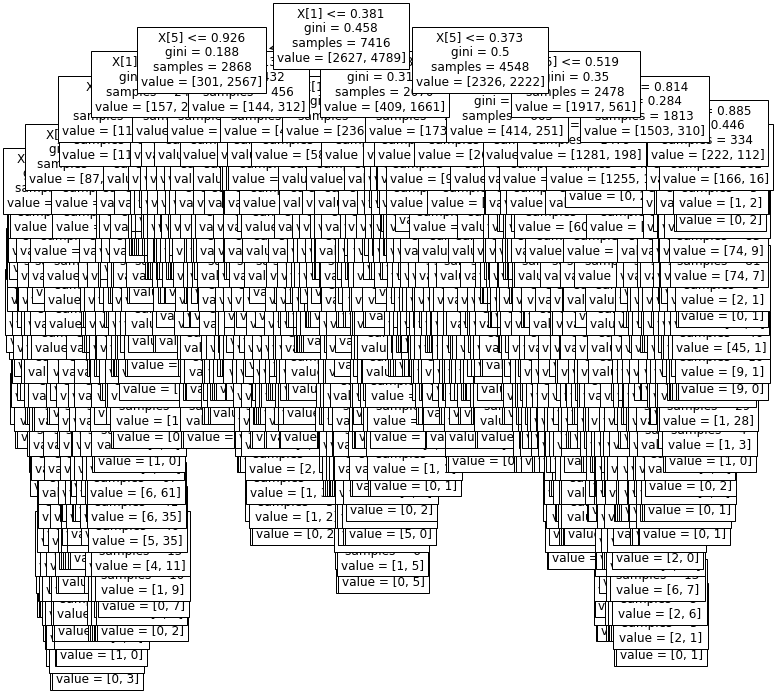

In [16]:
plt.figure(figsize=(12,12))
tree.plot_tree(strom,fontsize = 12)

# 3. Hyperparameter tuning

1. max_depth = limituje hĺbku maximálnou hodnotou
2. min_samples_leaf = minimálny počet samplov na 1 liste
3. max_leaf_nodes = maximálny konečný počet listov
4. max_features = určuje počet parametrov ktoré sa náhodne vyberú a použijú pri rozdelovaní

In [17]:
lst = []
for i in range(1,30):
    lst.append(predict_tree(i))

Depth =  1
Accuracy =  0.6678802588996764  Precision =  0.890282131661442  Recall =  0.5433673469387755
Depth =  2
Accuracy =  0.8305016181229773  Precision =  0.8496652465003043  Recall =  0.8903061224489796
Depth =  3
Accuracy =  0.8543689320388349  Precision =  0.8886743886743886  Recall =  0.8807397959183674
Depth =  4
Accuracy =  0.8543689320388349  Precision =  0.8856960408684547  Recall =  0.8845663265306123
Depth =  5
Accuracy =  0.8559870550161812  Precision =  0.8594306049822064  Recall =  0.9241071428571429
Depth =  6
Accuracy =  0.8495145631067961  Precision =  0.851764705882353  Recall =  0.923469387755102
Depth =  7
Accuracy =  0.8640776699029126  Precision =  0.8888888888888888  Recall =  0.8979591836734694
Depth =  8
Accuracy =  0.8640776699029126  Precision =  0.8893805309734514  Recall =  0.8973214285714286
Depth =  9
Accuracy =  0.8547734627831716  Precision =  0.8683729433272395  Recall =  0.9088010204081632
Depth =  10
Accuracy =  0.857200647249191  Precision =  0.

Najlepšie vyšla presnosť hĺbkam medzi 3 a 10, pri čom, najlepšia bola hĺbka = 8
Najlepší precision bol v hĺbkach 1,3,7,8 a najlepší recall v 5,6,7,8
Teda pri skúšaní ďaľších parametrov sa budeme sústrediť na hĺbku od 3 po 8
Ďalej sa pozrieme na parameter min_samples_leaf ktorý určuje minimálny počet vzorky na liste

In [25]:
def predict_tree_MinSample(i,j):
    print("Depth = ",i," Min sample leaf = ",j)
    clf = DecisionTreeClassifier(max_depth = i,min_samples_leaf = j)
    clf.fit(X_train,y_train)
    pred = clf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    rec = recall_score(y_test, pred)
    prec= precision_score(y_test, pred)
    print("Accuracy = ",acc," Precision = ",prec," Recall = ",rec)
    return clf

In [26]:
for j in range (1,400,50):
    for i in range(3,9):
        predict_tree_MinSample(i,j)

Depth =  3  Min sample leaf =  1
Accuracy =  0.8543689320388349  Precision =  0.8886743886743886  Recall =  0.8807397959183674
Depth =  4  Min sample leaf =  1
Accuracy =  0.8543689320388349  Precision =  0.8856960408684547  Recall =  0.8845663265306123
Depth =  5  Min sample leaf =  1
Accuracy =  0.8559870550161812  Precision =  0.8594306049822064  Recall =  0.9241071428571429
Depth =  6  Min sample leaf =  1
Accuracy =  0.8499190938511327  Precision =  0.8522660388463802  Recall =  0.923469387755102
Depth =  7  Min sample leaf =  1
Accuracy =  0.863673139158576  Precision =  0.8883280757097792  Recall =  0.8979591836734694
Depth =  8  Min sample leaf =  1
Accuracy =  0.8644822006472492  Precision =  0.889943074003795  Recall =  0.8973214285714286
Depth =  3  Min sample leaf =  51
Accuracy =  0.8543689320388349  Precision =  0.8886743886743886  Recall =  0.8807397959183674
Depth =  4  Min sample leaf =  51
Accuracy =  0.8543689320388349  Precision =  0.8886743886743886  Recall =  0.88

Pri kombinácii maximálnej hĺbky 8 a minimálneho počtu samplov 51 bola maximálna presnosť 86,9% zatiaľ najvyššia dosiahnutá
Ako ďaľšie vyskúšame skombinovať viaceré parametre ako max_lead a min_samples

In [27]:
def predict_tree_MaxLeaf(i,j,acc_arr,k,l):
    print("Min Samples = ",i," Max leaf = ",j)
    clf = DecisionTreeClassifier(max_leaf_nodes = j,min_samples_leaf = i,max_features = k,random_state = l)
    clf.fit(X_train,y_train)
    pred = clf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    acc_arr.append(acc)
    rec = recall_score(y_test, pred)
    prec= precision_score(y_test, pred)
    print("Accuracy = ",acc," Precision = ",prec," Recall = ",rec)
    return clf

In [28]:
acc_arr = []
for j in range (30,71,10):
    for i in range(30,140,10):
        predict_tree_MaxLeaf(j,i,acc_arr,6,1)

Min Samples =  30  Max leaf =  30
Accuracy =  0.8733818770226537  Precision =  0.9004467134652202  Recall =  0.8998724489795918
Min Samples =  30  Max leaf =  40
Accuracy =  0.8681229773462783  Precision =  0.8866749688667497  Recall =  0.9081632653061225
Min Samples =  30  Max leaf =  50
Accuracy =  0.8677184466019418  Precision =  0.8846869187848729  Recall =  0.9100765306122449
Min Samples =  30  Max leaf =  60
Accuracy =  0.8677184466019418  Precision =  0.8846869187848729  Recall =  0.9100765306122449
Min Samples =  30  Max leaf =  70
Accuracy =  0.8648867313915858  Precision =  0.885625  Recall =  0.9036989795918368
Min Samples =  30  Max leaf =  80
Accuracy =  0.8648867313915858  Precision =  0.885625  Recall =  0.9036989795918368
Min Samples =  30  Max leaf =  90
Accuracy =  0.8648867313915858  Precision =  0.885625  Recall =  0.9036989795918368
Min Samples =  30  Max leaf =  100
Accuracy =  0.8648867313915858  Precision =  0.885625  Recall =  0.9036989795918368
Min Samples =  

In [29]:
index = acc_arr.index(max(acc_arr))
print("Acc = ",acc_arr[index], " index = ",index)

Acc =  0.8733818770226537  index =  0


V prípade pre minimálny počet samplov = 30 a maximálny počet listov = 30 je presnosť 87,33%, môžme skúsiť upresniť s parametrami max_features a random_state

In [30]:
# bezi zopar minut
acc_arr = []
lst_final = []
for j in range (25,35):
    for i in range (25,35):
        for k in range (1,7):
            for l in range (35,45):
                lst_final.append(predict_tree_MaxLeaf(j,i,acc_arr,k,l))

Min Samples =  25  Max leaf =  25
Accuracy =  0.7475728155339806  Precision =  0.7489451476793249  Recall =  0.9056122448979592
Min Samples =  25  Max leaf =  25
Accuracy =  0.7233009708737864  Precision =  0.7309299895506792  Recall =  0.892219387755102
Min Samples =  25  Max leaf =  25
Accuracy =  0.7103559870550162  Precision =  0.7762645914396887  Recall =  0.7633928571428571
Min Samples =  25  Max leaf =  25
Accuracy =  0.7629449838187702  Precision =  0.7573375262054507  Recall =  0.9215561224489796
Min Samples =  25  Max leaf =  25
Accuracy =  0.7682038834951457  Precision =  0.7506297229219143  Recall =  0.9502551020408163
Min Samples =  25  Max leaf =  25
Accuracy =  0.7686084142394822  Precision =  0.8081683168316832  Recall =  0.8329081632653061
Min Samples =  25  Max leaf =  25
Accuracy =  0.8207928802588996  Precision =  0.8444580526638089  Recall =  0.8794642857142857
Min Samples =  25  Max leaf =  25
Accuracy =  0.7512135922330098  Precision =  0.7509215376513955  Recall

In [32]:
index = acc_arr.index(max(acc_arr))
print("Acc = ",acc_arr[index], " index = ",index)
lst_final[index].get_params()

Acc =  0.8802588996763754  index =  38


{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 4,
 'max_leaf_nodes': 25,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 25,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 43,
 'splitter': 'best'}

Pri náhodnom výbere 4 atribútov, random_state = 43, max_leaf = 25 a min_samples = 25 sme dosiahli presnosť až 88%, precíznosť 90% a recall 91%
Nakoniec môžme daný strom vykresliť

[Text(364.7414634146341, 836.3076923076923, 'X[3] <= 0.886\ngini = 0.458\nsamples = 7416\nvalue = [2627, 4789]'),
 Text(228.64390243902437, 769.4030769230769, 'X[4] <= 0.372\ngini = 0.406\nsamples = 6269\nvalue = [1776, 4493]'),
 Text(87.10243902439024, 702.4984615384615, 'X[5] <= 0.376\ngini = 0.422\nsamples = 2329\nvalue = [706, 1623]'),
 Text(43.55121951219512, 635.5938461538461, 'gini = 0.222\nsamples = 944\nvalue = [120, 824]'),
 Text(130.65365853658534, 635.5938461538461, 'gini = 0.488\nsamples = 1385\nvalue = [586, 799]'),
 Text(370.1853658536585, 702.4984615384615, 'X[4] <= 0.423\ngini = 0.396\nsamples = 3940\nvalue = [1070, 2870]'),
 Text(217.7560975609756, 635.5938461538461, 'X[2] <= 0.204\ngini = 0.309\nsamples = 304\nvalue = [58, 246]'),
 Text(174.20487804878047, 568.6892307692308, 'gini = 0.185\nsamples = 68\nvalue = [7, 61]'),
 Text(261.3073170731707, 568.6892307692308, 'X[3] <= 0.739\ngini = 0.339\nsamples = 236\nvalue = [51, 185]'),
 Text(217.7560975609756, 501.78461538

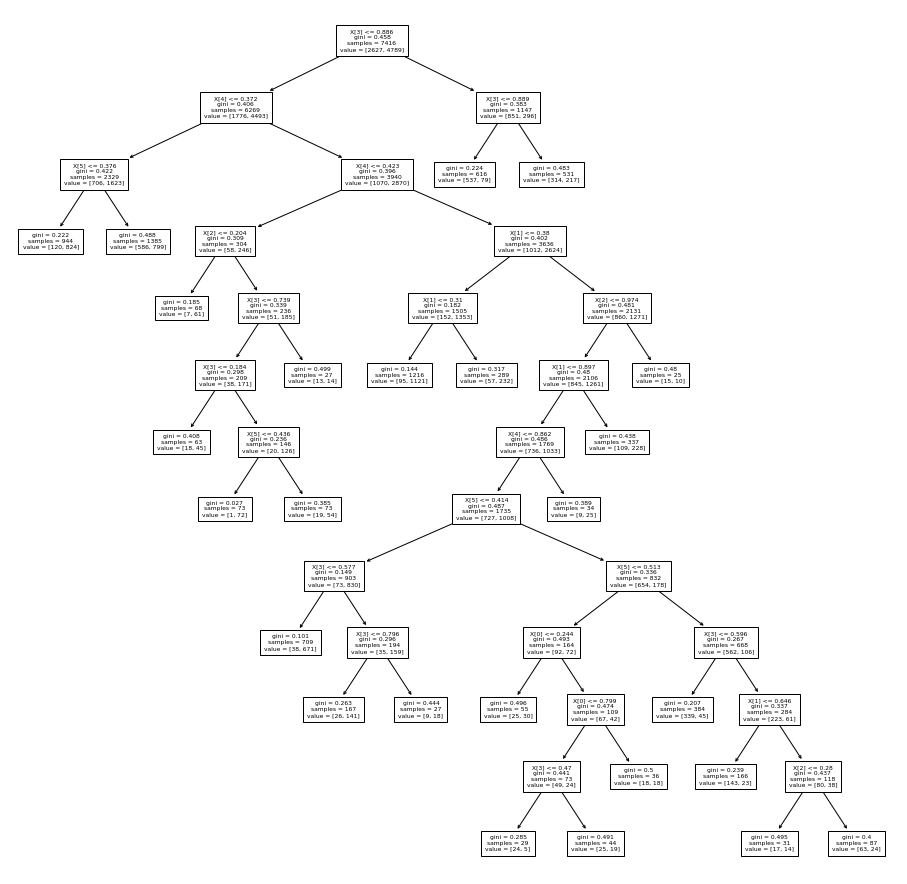

In [33]:
plt.figure(figsize=(16,16))
tree.plot_tree(lst_final[3],fontsize = 6)

# 4. Vyhodnotenie

In [31]:
filename2 = "020/labor.csv"
labor = pd.read_csv(filename2, sep='\t', index_col=0)

labor.loc[labor['smoker'] == 'yes', 'smoker']='Y'
labor.loc[labor['smoker'] == 'no', 'smoker']='N'

labor['weight']=labor['weight'].apply(abs)
labor = labor.drop_duplicates()

indic = labor['indicator']
labor.drop(labels=['indicator'], axis=1,inplace = True)
labor.insert(0,'indicator',indic)

labor = labor.reset_index(drop = True)

labor=labor.drop(['name','relationship','ssn', 'smoker'],axis=1)
labor

,indicator,er-cv,leukocyty,weight,etytr,erytrocyty,trombocyty,hemoglobin,ast,alp,alt,hematokrit,hbver
0,1.0,43.09887,4.47526,65.57593,5.96219,6.20665,5.71427,5.06667,57.92930,57.60257,5.12934,7.11081,6.32708
1,1.0,32.51734,4.41339,58.47779,5.44840,5.58217,6.29619,6.90945,61.47846,83.38342,10.59365,8.52324,9.06429
2,1.0,54.39106,4.71119,37.58396,6.75478,6.36030,6.67129,4.08668,59.37033,31.60935,10.72644,8.41874,7.11435
3,1.0,45.79943,5.38079,88.06628,6.33099,5.45784,6.24957,5.57164,50.31551,75.29715,9.26557,4.69702,7.00724
4,0.0,48.81261,4.72469,44.59816,6.62153,6.36262,6.44608,6.49617,50.44424,84.90135,9.31196,6.31221,8.54503
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9883,1.0,57.11218,5.26323,51.27708,5.00976,4.91856,6.48513,3.03796,41.27456,13.47601,13.88191,5.86663,6.55392
9884,0.0,55.86133,8.38651,152.99318,9.27774,5.78542,4.73446,4.92447,44.92183,56.03309,8.23807,6.50680,7.18183
9885,1.0,20.08620,4.81549,89.14354,6.54037,5.12928,5.28566,7.07261,20.39526,75.88338,7.06386,5.16492,8.92604
9886,1.0,40.47220,5.28603,18.62037,6.22798,6.35608,6.37370,5.59105,18.04463,79.92407,12.06706,5.72674,8.84950


In [34]:
def my_fill_na(arg1,ind):
    labor.loc[labor['indicator'] == ind , arg1] = labor.loc[labor['indicator'] == ind , arg1].fillna(
    (labor.loc[labor['indicator'] == ind , arg1].mean()))
    
def drop_na(df):
    return df.copy().dropna()

def use_my_fill_na(atributes):
    for atribute in atributes:
        my_fill_na(atribute, 0)
        my_fill_na(atribute, 1)

In [35]:
# MISSING VALUES
# labor = drop_na(labor)
use_my_fill_na(labor.columns)

In [36]:
import random
def detect_outlier(atr):
    lower = atr.quantile(0.25) - 1.5
    upper = atr.quantile(0.75) + 1.5
    
    return atr[(atr > upper) | (atr < lower)]

def detect_upper_lower_outliers(atr):
    lower = atr.quantile(0.25) - 1.5
    upper = atr.quantile(0.75) + 1.5
    
    return atr[(atr > upper)], atr[(atr < lower)]

# Tato funkcia najde vrchnych a spodnych outlierov a vyplni ich nahodnou hodnotou medzi minimom bez outlierov a 10 spodnych % pripadne maximom bez outlierov a 10 vrchnych %
def fill_outliers(df, atr):
    df.loc[detect_upper_lower_outliers(df[atr])[0].index, [atr]] = random.uniform(df.drop(detect_upper_lower_outliers(df[atr])[0].index)[atr].quantile(0.90), df.drop(detect_upper_lower_outliers(df[atr])[0].index)[atr].max())
    df.loc[detect_upper_lower_outliers(df[atr])[1].index, [atr]] = random.uniform(df.drop(detect_upper_lower_outliers(df[atr])[1].index)[atr].min(), df.drop(detect_upper_lower_outliers(df[atr])[1].index)[atr].quantile(0.10))
    df[atr]
    
def handle_outlier(df, atributes, handle_type='fill'):
    result = df.copy()
    if handle_type == 'fill':
        for atribute in atributes:
            fill_outliers(result, atribute)
    elif handle_type == 'drop':
        for atribute in atributes:
            result.drop(detect_outlier(result[atribute]).index, inplace=True)
    else:
        print("incorrect handle_type")
    return result

In [37]:
# OUTLINERS
labor = handle_outlier(labor, labor.columns, 'fill')
# labor = handle_outlier(labor, labor.columns, 'drop')

In [38]:
# PREPROCESSING
split_by = 0.75
labor_train = labor.sample(frac=split_by,random_state=200)
labor_train.sort_index()

labor_test = labor
labor_test = pd.merge(labor_test,labor_train,indicator = True, how = 'outer').query('_merge=="left_only"').drop('_merge', axis = 1)

In [39]:
# TRANSFORMATION
atributes = labor_train.columns
def my_fit(df, scaler, atributes):
    return scaler.fit_transform(df.loc[:, atributes])

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(labor_train.loc[:, atributes])

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaled = scaler.fit_transform(labor_train.loc[:, atributes])

# from sklearn.preprocessing import RobustScaler
# scaler = RobustScaler()
# scaled = scaler.fit_transform(labor_train.loc[:, atributes])

# from sklearn.preprocessing import PowerTransformer
# power = PowerTransformer(method='yeo-johnson', standardize=True)
# trans = power.fit_transform(labor_train.loc[:, atributes])

# from sklearn.preprocessing import QuantileTransformer
# qt = QuantileTransformer(n_quantiles=10, random_state=0)
# labor_train = my_fit(labor_train, qt, atributes)

In [40]:
# VYBER ATRIBUTOV
k=7
labor_train =  pd.DataFrame(labor_train,columns = atributes)

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

y = labor_train['indicator']
labor_train_proc = SelectKBest(mutual_info_regression, k=k).fit_transform(labor_train, y)

# Vráti array názvov stĺpcov
def get_names(w_names, wo_names):
    names = w_names.columns
    ret_val = []
    i = 0
    for x in wo_names[0]:
        j = 0
        for y in w_names.iloc[0]:
            if j<i:
                j+=1
                continue
            if x == y:
                ret_val.append(names[j])
                i = j
                break
            j+=1
    return (ret_val)

labor_train_proc = pd.DataFrame(labor_train_proc,columns = get_names(labor_train,labor_train_proc))

from numpy import arange

def get_order():
    y = labor_train_proc['indicator']
    for x in arange(2, k+1, 1):
        new_arr = SelectKBest(mutual_info_regression, k=x).fit_transform(labor_train_proc, y)
        print(get_names(labor_train, new_arr)[1:])
        
get_order()

['leukocyty']
['leukocyty', 'hematokrit']
['leukocyty', 'hemoglobin', 'hematokrit']
['leukocyty', 'trombocyty', 'hemoglobin', 'hematokrit']
['leukocyty', 'trombocyty', 'hemoglobin', 'hematokrit', 'hbver']
['leukocyty', 'trombocyty', 'hemoglobin', 'ast', 'hematokrit', 'hbver']


In [41]:
# LEARNING 2
X_train = labor_train[['er-cv','leukocyty','trombocyty','hemoglobin','ast','hematokrit']]
y_train = labor_train[['indicator']]
X_test = labor_test[['er-cv','leukocyty','trombocyty','hemoglobin','ast','hematokrit']]
y_test = labor_test[['indicator']]

from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import tree

def predict_tree(i):
    if (i == 0):
        clf = DecisionTreeClassifier()
    else:
        print("Depth = ",i)
        clf = DecisionTreeClassifier(max_depth = i)
    clf.fit(X_train,y_train)
    pred = clf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    rec = recall_score(y_test, pred)
    prec= precision_score(y_test, pred)
    print("Accuracy = ",acc," Precision = ",prec," Recall = ",rec)
    return clf

predict_tree(8)

Depth =  8
Accuracy =  0.8697411003236246  Precision =  0.8943037974683544  Recall =  0.9011479591836735


DecisionTreeClassifier(max_depth=8)

In [42]:
# LEARNING 3
def predict_tree_MinSample(i,j):
    print("Depth = ",i," Min sample leaf = ",j)
    clf = DecisionTreeClassifier(max_depth = i,min_samples_leaf = j)
    clf.fit(X_train,y_train)
    pred = clf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    rec = recall_score(y_test, pred)
    prec= precision_score(y_test, pred)
    print("Accuracy = ",acc," Precision = ",prec," Recall = ",rec)
    return clf

predict_tree_MinSample(8,51)

Depth =  8  Min sample leaf =  51
Accuracy =  0.8697411003236246  Precision =  0.9077225130890052  Recall =  0.8845663265306123


DecisionTreeClassifier(max_depth=8, min_samples_leaf=51)

## VYSLEDKY
Ako defoultne budem pouzivat rozlozenie: 
- Strategia riesenia chybajucich hodnot: my_fill_na
- Strategia riesenia outlinerov: fill_outliners
- Scaling resp Transforming: MinMaxScaler
- Vyber atributov: k=7
- Ensamble learning: predict_tree_MinSample

Postupne budeme v kazdej kategorii menit vybrane algoritmy a vysledky accuracy zapisovat

### Strategia riesenia chybajucich hodnot
- my_fill_na: 0.8697411003236246
- drop_na: 0.8694560669456067

### Strategia riesenia outlinerov
- fill: 0.8697411003236246
- drop: 0.8981481481481481

### Scaling resp Transforming
- MinMaxScaler: 0.8697411003236246
- StandartScaler: 0.8685275080906149
- RobustScaler: 0.8673139158576052
- PowerTransformer: 0.8689320388349514
- QuantileTranformer: 0.3656957928802589

### Vyber Atributov
- k=3: 0.8681229773462783
- k=5: 0.8697411003236246
- k=7: 0.8697411003236246

### Ensamble learning
- OneR: 0.7148058252427184
- PredictTree: 0.8717637540453075
- PredictTreeMinMax: 0.8677184466019418

## ZHODNOTENIE
Najlepsiu accuracy sme dosiahli pri nasledujucich nastaveniach:
- Strategia riesenia chybajucich hodnot: my_fill_na
- Strategia riesenia outlinerov: **drop_outliners**
- Scaling resp Transforming: MinMaxScaler
- Vyber atributov: k=7
- Ensamble learning: predict_tree_MinSample